# Ensemble Challenge
Goal: to capture the complexity and nuances around the evolution of the pandemic at various stages and locations.

## Consider the following settings:
1. *Timepoint 1*: May 1st, 2020. Setting: Michigan State at the beginning of the pandemic when masking was the main preventative measure. No vaccines available.
2. *Timepoint 2*: May 1st, 2021. Setting: Michigan State prior to the arrival of the Delta variant. Vaccines available.
3. *Timepoint 3*: December 15th, 2021. Setting: Michigan State during the start of the first Omicron wave.

4. *BONUS*: Consider the same three time points, but change the setting to Louisiana, which had different COVID-19 dynamics compared to the Northern and Northeastern states.

## ...and related questions for each:
1. What is the most relevant data to use for model calibration?
2. What was our understanding of COVID-19 viral mechanisms at the time? For example, early in the pandemic, we didn't know if reinfection was a common occurance, or even possible.
3. What are the parameters related to contagiousness/transmissibility and severity of the dominant strain at the time?
4. What policies were in place for a stated location, and how can this information be incorporated into models? (See https://www.bsg.ox.ac.uk/research/covid-19-government-response-tracker for time series of interventions.)

## For each setting:
1. (a) Take a single model, calibrate it using historical data prior to the given date, and create a 4-week forecast for cases, hospitalizations, and deaths beginning on the given date. (b) Evaluate the forecast using the COVID-19 Forecasting Hub Error Metrics (WIS, MAE). The single model evaluation should be done in the same way as the ensemble.

2. Repeat (1), but with an ensemble of different models.

    a. It is fine to calibrate each model independently and weight naively.
    
    b. It would also be fine to calibrate the ensemble as a whole, assigning weights to the different component models, so that you minimize the error of the ensemble vs. historical data.
    
    c. Use the calibration scores and error metrics computed by the CDC Forecasting Hub. As stated on their [website](https://covid19forecasthub.org/doc/reports/): 
    
    “Periodically, we evaluate the accuracy and precision of the [ensemble forecast](https://covid19forecasthub.org/doc/ensemble/) and component models over recent and historical forecasting periods. Models forecasting incident hospitalizations at a national and state level are evaluated using [adjusted relative weighted interval scores (WIS, a measure of distributional accuracy)](https://arxiv.org/abs/2005.12881), and adjusted relative mean absolute error (MAE), and calibration scores. Scores are evaluated across weeks, locations, and targets. You can read [a paper explaining these procedures in more detail](https://www.medrxiv.org/content/10.1101/2021.02.03.21250974v1), and look at [the most recent monthly evaluation reports](https://covid19forecasthub.org/eval-reports). The final report that includes case and death forecast evaluations is 2023-03-13.” 

3. Produce the forecast outputs in the format specified by the CDC forecasting challenge, including the specified quantiles.

## Data
Use the following data sources:
1. Cases: [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv), [Reich Lab](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Cases.csv) (pulled from Johns Hopkins, but formatted)

2. Hospitalizations: [HealthData.gov](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh)

3. Deaths: [Johns Hopkins](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Deaths.csv), [Reich Lab](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Cumulative%20Deaths.csv)

In [1]:
# Load dependencies and functions from utils file
from pyciemss.utils.toronto_hackathon_utils.toronto_ensemble_challenge_utils import *

### Set the region of interest and infectious period, get the DataFrame containing case and hospital census data, and death data for that region, and plot said data if desired

      index       date  case_census  hosp_census  cumulative_deaths
0         0 2020-01-22          0.0          NaN                0.0
1         1 2020-01-23          0.0          NaN                0.0
2         2 2020-01-24          0.0          NaN                0.0
3         3 2020-01-25          0.0          NaN                0.0
4         4 2020-01-26          0.0          NaN                0.0
...     ...        ...          ...          ...                ...
1251   1251 2023-06-26          NaN         26.0                NaN
1252   1252 2023-06-27          NaN         21.0                NaN
1253   1253 2023-06-28          NaN         17.0                NaN
1254   1254 2023-06-29          NaN         23.0                NaN
1255   1255 2023-06-30          NaN         27.0                NaN

[1256 rows x 5 columns]


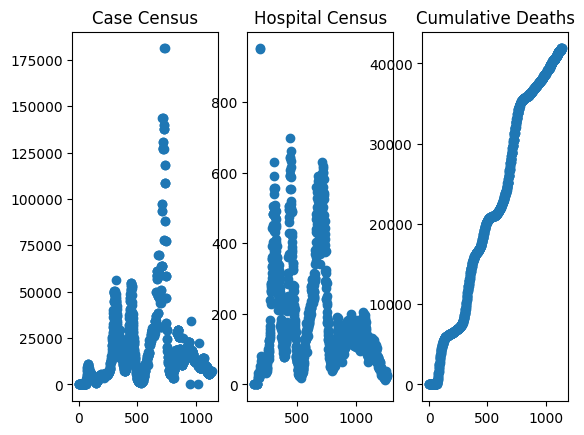

In [4]:
# Declare the region of interest and infectious period, get the DataFrame for that region
US_region = "MI" # 2-letter state abbreviation string (or "US")
infectious_period = 7 # duration of infectious period (in days)
plot_data = True # plot the data when true

# Note: source datasets are quite large, so this will take a minute to run
# data = get_case_hosp_death_data(US_region = US_region, infectious_period = infectious_period, make_csv=False)
data = data.reset_index()
print(data)

# FYI: hosp data starts around 07/14/2020 and is NaN before

if plot_data:
    # Plot case census data
    plt.subplot(1, 3, 1)
    plt.plot(data.index, data["case_census"], 'o')
    plt.title("Case Census")

    # Plot hosp census data
    plt.subplot(1, 3, 2)
    plt.plot(data.index, data["hosp_census"], 'o')
    plt.title("Hospital Census")

    # Plot cumulative deaths
    plt.subplot(1, 3, 3)
    plt.plot(data.index, data["cumulative_deaths"], 'o')
    plt.title("Cumulative Deaths")

### Set relevant dates, test and train intervals

In [10]:
# Set train start date at the first available datapoint to use all historic data available
train_start_date = str(data["date"][0]) # this is 01/22/2020

# Given timepoints will act as test start dates
timepoint1 = "2020-05-01" 
timepoint2 = "2021-05-01"
timepoint3 = "2021-12-15"

# Set test end dates 4 weeks after timepoints
test_end_date1 = "2020-05-29"
test_end_date2 = "2021-05-29"
test_end_date3 = "2022-01-12"

### Set up train and test data

In [13]:
# Gather train and test data corresponding to Timepoint 1
train_data1, train_cases1, train_timepoints1, test_cases1, test_timepoints1, all_timepoints1 = \
get_train_test_data(data, train_start_date, timepoint1, test_end_date1)

# Set the start time (for all simulations)
start_time = train_timepoints1[0] - 1e-5

# Gather train and test data corresponding to Timepoint 2
train_data2, train_cases2, train_timepoints2, test_cases2, test_timepoints2, all_timepoints2 = \
get_train_test_data(data, train_start_date, timepoint2, test_end_date2)

# Gather train and test data corresponding to Timepoint 3
train_data3, train_cases3, train_timepoints3, test_cases3, test_timepoints3, all_timepoints3 = \
get_train_test_data(data, train_start_date, timepoint3, test_end_date3)

In [9]:
str(data["date"][0])

'2020-01-22 00:00:00'

In [15]:
train_data3

[(0.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (1.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (2.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (3.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (4.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (5.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (6.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (7.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (8.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (9.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (10.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (11.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (12.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (13.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (14.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (15.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (16.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (17.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (18.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (19.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (20.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (21.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (22.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (23.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (24.0, {'Cases': 0.0, 'Deaths': 0.0}),
 (25.0, {'

## Models:
1. You may consider any of the models you have seen in the started kit, or 6-month hackathon and evaluation scenarios.

2. You may search for new models in the literature, or use TA2 model extension/transformation capabilities to modify models already in Terarium.

### Load dependencies for ensembling

In [ ]:
# Load ensembling dependencies

import os
#import urllib.request, json 
import pandas as pd
#from IPython.display import HTML
#from IPython import display
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)

from pyciemss.Ensemble.interfaces import (
    load_and_sample_petri_ensemble,
    load_and_calibrate_and_sample_ensemble_model,
#     setup_ensemble_model,
#     reset_ensemble_model,
#     intervene_ensemble_model,
#     calibrate_ensemble_model,
#     sample_ensemble_model
)

import numpy as np
from typing import Iterable
from pyciemss.utils.interface_utils import (
    assign_interventions_to_timepoints,
    interventions_and_sampled_params_to_interval,
    convert_to_output_format
)
from pyciemss.utils import get_tspan
# import matplotlib.pyplot as plt
import torch
from torch import tensor

import mira
from mira.metamodel import Concept, ControlledConversion, GroupedControlledConversion, Initial, NaturalConversion, Parameter, Template, TemplateModel
from mira.modeling.viz import GraphicalModel
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from torch import tensor
import torch
from pyciemss.interfaces import sample, calibrate
from pyciemss.PetriNetODE.interfaces import load_petri_model, sample_petri, calibrate_petri, setup_petri_model, load_and_sample_petri_model
from pyciemss.PetriNetODE.base import * #get_name
from torch import tensor
import sympy
from sympytorch import SymPyModule

### Get models to be ensembled

In [ ]:
FIRST_PATH = "../Examples_for_TA2_Model_Representation/"

# Model 1
filename1 = "SEIARHDS_AMR.json"
filename1 = os.path.join(FIRST_PATH, filename1)
model1 = load_petri_model(filename1, add_uncertainty=True)

# Model 2
filename2 = "SEIARHD_AMR.json"
filename2 = os.path.join(FIRST_PATH, filename2)
model2 = load_petri_model(filename2, add_uncertainty=True)

# Model 3
filename3 = "SIRHD_AMR.json"
filename3 = os.path.join(FIRST_PATH, filename3)
model3 = load_petri_model(filename3, add_uncertainty=True)

### Create functions to define solution mapping dictionaries

In [ ]:
# Define type of solution mapping required by each model
def solution_mapping_inf(model_solution: dict) -> dict:
    # solution mapping for models with one infectious category
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["infectious_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

def solution_mapping_symp(model_solution: dict) -> dict:
    # solution mapping for models with a symptomatic and an asymptomatic population
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["symptomatic_population"] + model_solution["asymptomatic_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

### Create start states for each model at designated time points

In [ ]:
def create_start_state1(data, start_date, total_pop):
    '''Create the start state for Model 1 from data using our best guesses for
    mapping from observed variables to model state variables.'''
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Extinct"] = start_state['cumulative_deaths']

    # Assume Threatened maps to hospitalizations, and, if no hosp. data, assume 1 hosp. per 100 recorded cases
    if np.isnan(start_state['hospital_census']):
        returned_state["Threatened"] = start_state['case_census'] / 100
    else:
        returned_state["Threatened"] = start_state['hospital_census']

    # Assume one undetected case per detected case, and evenly distribute across each category of infectiousness
    returned_state["Diagnosed"] = start_state['case_census'] / 2
    returned_state["Recognized"] = start_state['case_census'] / 2
    returned_state['Infected'] = start_state['case_census'] / 2  # * 10
    returned_state['Ailing'] = start_state['case_census'] / 2  # returned_state["Threatened"] * 100

    # Assume ten individuals are Healed for every one death
    returned_state['Healed'] = start_state['cumulative_deaths'] * 10
    returned_state['Susceptible'] = total_pop - sum(returned_state.values())
    # print(returned_state)
    assert (returned_state['Susceptible'] > 0)
    return {k: v / total_pop for k, v in returned_state.items()}

### Set up and calibrate the ensemble model to data

In [ ]:
models = [model1, model2, model3]
start_states = [start_state1, start_state2, start_state3]
num_samples = 100
num_iterations = 100
ensemble_weights = [1/3, 1/3, 1/3]

[ensemble_prior_forecasts, calibrated_solution, all_timepoints] = ensemble_calibration(models, synth_data_df,
                                    start_states, num_samples, num_iterations, 
                                    ensemble_weights, train_start_date, test_start_date,  
                                    test_end_date, data_total_population)

## Only now we have methods like: load and sample, load and calibrate and sample ensemble

### Plot the results (posterior distributions and weights)

In [ ]:
# Plot